# Major Crime Analysis The City of Toronto

## Highlights

Time of analysis: 2014 to 2018. 

⮚	Exploring and describing major crime rates in the city of Toronto

⮚	Determining correlates and predictors of crime?

⮚	Describing the possible trends and identifying how crime rates change over time?

⮚	Mapping hotspot areas for a major crime and forecasting future crime trends.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import calendar
from datetime import datetime
#*************************************************
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import folium #Folium is a powerful Python library that helps you create several types of Leaflet maps
import pingouin as pg # Pingouin is an open-source statistical package written in Python 3 and based mostly on Pandas and NumPy.
                      #Among the uses ANOVAs: N-ways, repeated measures, mixed, ancova, 
                      #Pairwise post-hocs tests (parametric and non-parametric) and pairwise correlations
                      #Robust, partial, distance and repeated measures correlations, Linear/logistic regression and mediation analysis
                      #Bayes Factors, Multivariate tests, Reliability and consistency, Effect sizes and power analysis
                      #Parametric/bootstrapped confidence intervals around an effect size or a correlation coefficient
                      #Circular statistics, Chi-squared tests, 
                      #Plotting: Bland-Altman plot, Q-Q plot, paired plot, robust correlation and more


## Load dataset

In [7]:
mci_df = pd.read_csv('all_merged.csv')
mci_df.head(2)

,index,occurrencedate,occurrenceyear,occurrencemonth,division,Hood_ID,type,neighbourhood,Lat,Long,merged1
0,1,2004-01-03T05:00:00.000Z,2004.0,NaN,D53,98,Other,Rosedale-Moore Park (98),43.685028,-79.392853,Homicide
1,2,2004-01-08T05:00:00.000Z,2004.0,NaN,D42,137,Shooting,Woburn (137),43.781536,-79.234962,Homicide


No duplicates, missing data are year and month, can be restored from occurence date

In [12]:
#check for duplicates
print('Duplicates:',mci_df.duplicated().any())


Duplicates: False


In [13]:
#Checking for missings
print('Missing Data')
mci_df.isnull().sum().sort_values(ascending=False)

Missing Data


occurrencemonth    353
merged1              0
Long                 0
Lat                  0
neighbourhood        0
type                 0
Hood_ID              0
division             0
occurrenceyear       0
occurrencedate       0
index                0
dtype: int64

In [20]:
# cleaning date format before proceeeding to date related analysis
# we can use occurencedate to replace missings of occurence related times(occurrenceyear, occurrencedayofweek, occurrencedayofyear, occurrenceday, occurrencemonth)
# convert dates to pandas datetime format
mci_df['occurrencedate'] = mci_df['occurrencedate'].astype('datetime64[ns]')
mci_df.head(2)

,index,occurrencedate,occurrenceyear,occurrencemonth,division,Hood_ID,type,neighbourhood,Lat,Long,merged1
434,827,2014-01-14 05:00:00,2014,1,D41,126,Other,Dorset Park (126),43.759132,-79.289589,Homicide
436,829,2014-01-29 05:00:00,2014,1,D23,8,Shooting,Humber Heights-Westmount (8),43.694614,-79.517342,Homicide


In [17]:
#generating missing months
mci_df['occurrencemonth'] = pd.DatetimeIndex(mci_df['occurrencedate']).month

In [27]:
# to change months in to thier respective string
import calendar
import datetime
mci_df['occurrencemonth'] = pd.DatetimeIndex(mci_df['occurrencemonth']).strftime('%b')

In [30]:
# generating occurrenceday from occurrencedate
mci_df['occurrenceday'] = pd.DatetimeIndex(mci_df['occurrencedate']).day

In [67]:
# generating occurrence week day from occurrencedate
mci_df['occurrencedayofweek'] = pd.DatetimeIndex(mci_df['occurrencedate']).weekday

In [70]:
#pd.DatetimeIndex(mci_df['occurrencedayofweek']).strftime('%A')
mci_df.occurrencedayofweek.unique()

array([1, 2, 6, 0, 5, 4, 3], dtype=int64)

Setting up the analysisi time to years 2014 to 2018. 

In [71]:
#include years from 2014 2018 
mci_df = mci_df[mci_df.occurrenceyear >=2014]
mci_df = mci_df[mci_df.occurrenceyear <=2018]

In [72]:
print(mci_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166853 entries, 434 to 168539
Data columns (total 13 columns):
index                  166853 non-null int64
occurrencedate         166853 non-null datetime64[ns]
occurrenceyear         166853 non-null Int32
occurrencemonth        166853 non-null object
division               166853 non-null object
Hood_ID                166853 non-null int64
type                   166853 non-null object
neighbourhood          166853 non-null object
Lat                    166853 non-null float64
Long                   166853 non-null float64
merged1                166853 non-null object
occurrenceday          166853 non-null int64
occurrencedayofweek    166853 non-null int64
dtypes: Int32(1), datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 17.3+ MB
None


# Explanatory analysis on MCI data

### Year to year by groups

In [73]:
mci_ct = pd.crosstab(mci_df.type, mci_df.occurrenceyear, margins=True)
mci_ct

occurrenceyear,2014,2015,2016,2017,2018,All
type,,,,,,
Assault,16375,17705,18475,18973,18617,90145
Auto Theft,3496,3195,3264,3558,4617,18130
Break and Enter,7178,6899,6387,6876,7485,34825
Other,15,15,25,15,25,95
Robbery,3585,3464,3613,3901,3522,18085
Shooting,27,26,41,39,51,184
Stabbing,16,18,9,11,20,74
Theft Over,994,1019,1012,1149,1141,5315
All,31686,32341,32826,34522,35478,166853


## Crime type by year

Text(0.5, 1.0, 'MCI by Year')

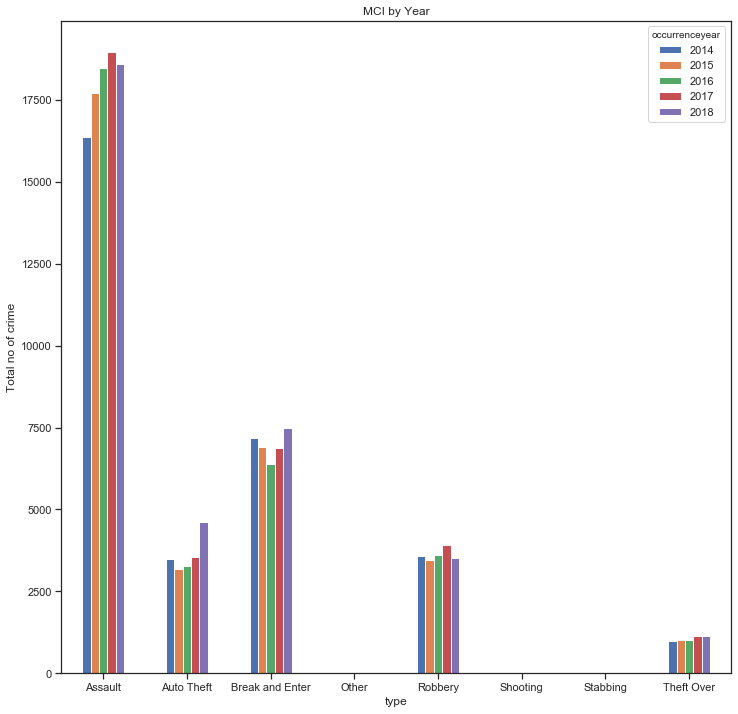

In [74]:
mci_ct_plot = pd.crosstab(mci_df.type, mci_df.occurrenceyear)
mci_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(12, 12));
plt.ylabel('Total no of crime')
plt.title('MCI by Year')

Text(0.5, 1.0, 'MCI by Year')

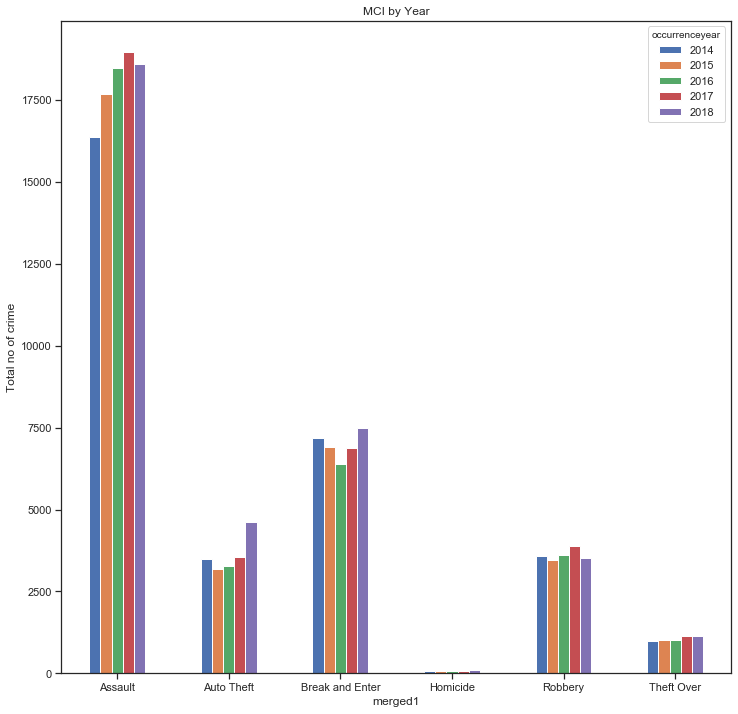

In [92]:
mci_ct_plot = pd.crosstab(mci_df.merged1, mci_df.occurrenceyear)
mci_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(12, 12));
plt.ylabel('Total no of crime')
plt.title('MCI by Year')

## Major crime by year

Text(0.5, 1.0, 'MCI by Year')

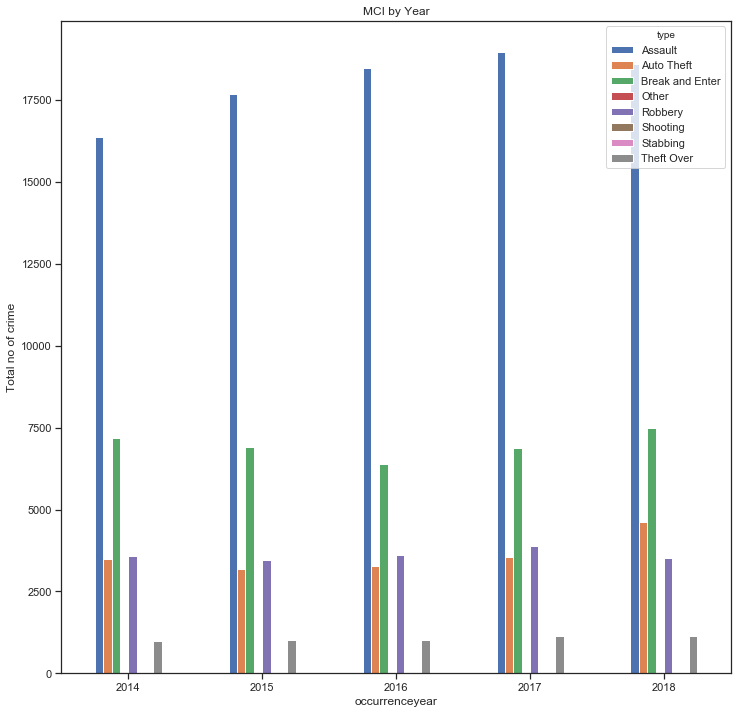

In [75]:
mci_ct_plot = pd.crosstab(mci_df.occurrenceyear, mci_df.type)
mci_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(12, 12));
plt.ylabel('Total no of crime')
plt.title('MCI by Year')

Text(0.5, 1.0, 'MCI by Year')

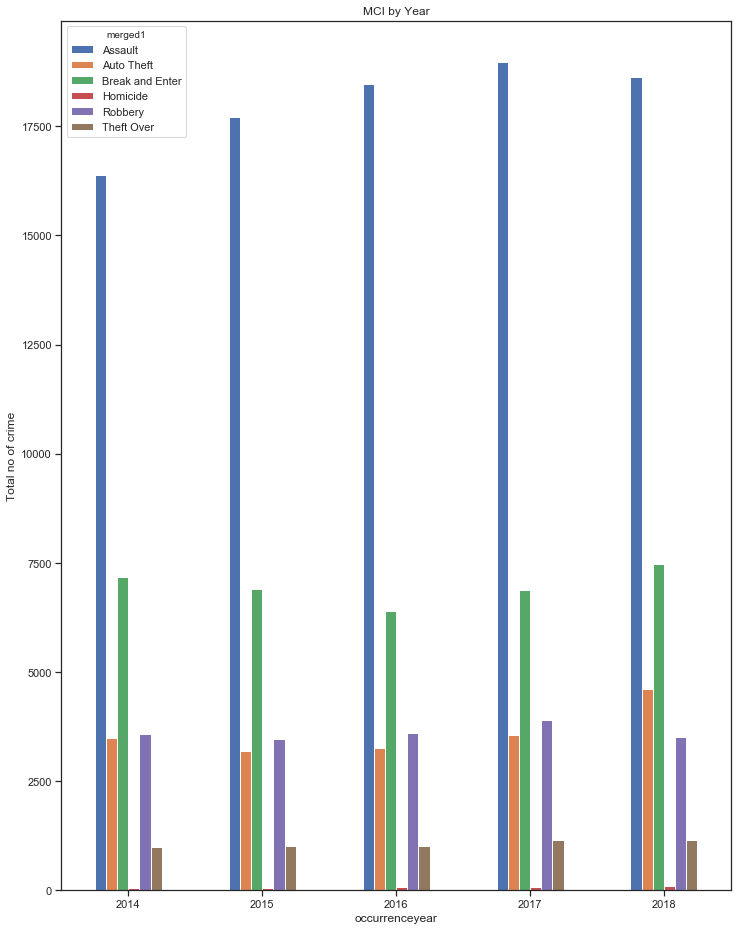

In [99]:
mci_ct_plot = pd.crosstab(mci_df.occurrenceyear, mci_df.merged1)
mci_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(12, 16));
plt.ylabel('Total no of crime')
plt.title('MCI by Year')

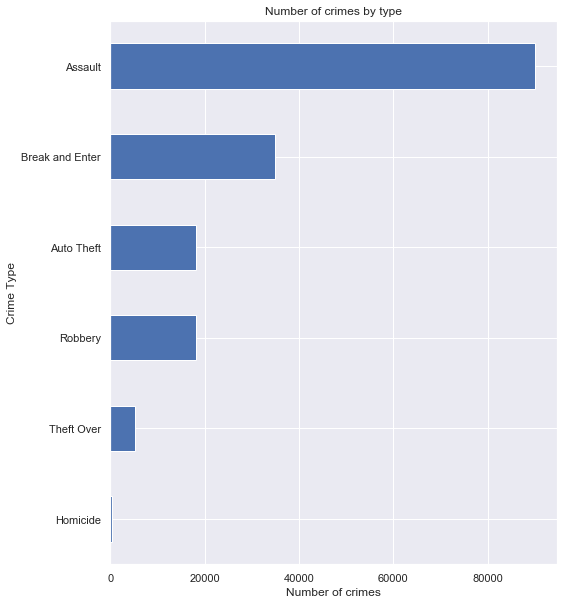

In [257]:
plt.figure(figsize=(8,10))
mci_df.groupby([mci_df['merged1']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

### Crime by days of the week

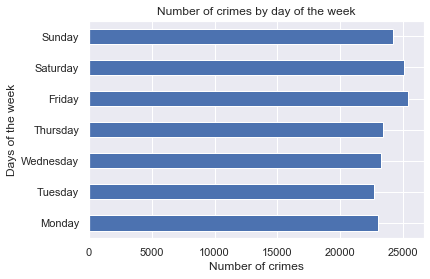

In [250]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
mci_df.groupby([mci_df.occurrencedayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

<b> extract </b>

The follwing analysis is after extract of MCI index from crosstab dataframe.

In [76]:
# remove row all from min/max analysis and create mci per year 
mciYearly = mci_ct.loc['All']
mci_ct = mci_ct.iloc[:-1,:]
mciYearly = mciYearly[:-1]
mciYearly

occurrenceyear
2014    31686
2015    32341
2016    32826
2017    34522
2018    35478
Name: All, dtype: int64

## Leading Crime for each year

In [81]:
# skip
print('Leading Crime')
print('*************************')
for i in range(0,mci_ct.shape[1]-1): 
    row = mci_ct.iloc[:,i][mci_ct.iloc[:,i] == mci_ct.iloc[:1,i].max()]
    print(row)
    print('*************************')

Leading Crime
*************************
type
Assault    16375
Name: 2014, dtype: int64
*************************
type
Assault    17705
Name: 2015, dtype: int64
*************************
type
Assault    18475
Name: 2016, dtype: int64
*************************
type
Assault    18973
Name: 2017, dtype: int64
*************************
type
Assault    18617
Name: 2018, dtype: int64
*************************


## Least occuring Crime for each year

In [82]:
print('Least occuring Crime')
print('*************************')
for i in range(0,mci_ct.shape[1]-1): 
    row = mci_ct.iloc[:,i][mci_ct.iloc[:,i] == mci_ct.iloc[:,i].min()]
    print(row)
    print('*************************')

Least occuring Crime
*************************
type
Other    15
Name: 2014, dtype: int64
*************************
type
Other    15
Name: 2015, dtype: int64
*************************
type
Stabbing    9
Name: 2016, dtype: int64
*************************
type
Stabbing    11
Name: 2017, dtype: int64
*************************
type
Stabbing    20
Name: 2018, dtype: int64
*************************


<b> Assault in Toronto is number the most frequently occurred type of crime, and the least occurring crime is robbery-buisness </b>

In [83]:
# for major crime indicator
description = mci_ct[0:-1].describe()
description

occurrenceyear,2014,2015,2016,2017,2018,All
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,4384.571429,4474.571429,4544.857143,4767.571429,4905.285714,23076.857143
std,5918.452694,6365.522311,6598.474077,6782.636849,6682.189230,32318.531276
min,15.000000,15.000000,9.000000,11.000000,20.000000,74.000000
25%,21.500000,22.000000,33.000000,27.000000,38.000000,139.500000
50%,3496.000000,3195.000000,3264.000000,3558.000000,3522.000000,18085.000000
75%,5381.500000,5181.500000,5000.000000,5388.500000,6051.000000,26477.500000
max,16375.000000,17705.000000,18475.000000,18973.000000,18617.000000,90145.000000


In [84]:
mci_ct[0:-1].kurtosis()

occurrenceyear
2014    2.899502
2015    3.655690
2016    4.181385
2017    3.919598
2018    3.280965
All     3.620219
dtype: float64

## histogram for the major crime indicators

occurrenceyear
2014    16375
2015    17705
2016    18475
2017    18973
2018    18617
Name: Assault, dtype: int64


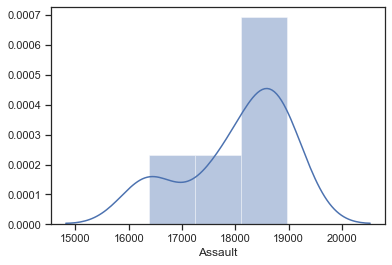

occurrenceyear
2014    3496
2015    3195
2016    3264
2017    3558
2018    4617
Name: Auto Theft, dtype: int64


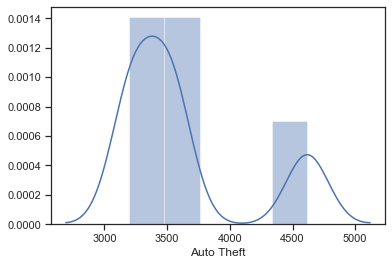

occurrenceyear
2014    7178
2015    6899
2016    6387
2017    6876
2018    7485
Name: Break and Enter, dtype: int64


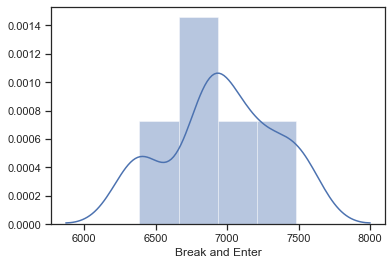

occurrenceyear
2014    15
2015    15
2016    25
2017    15
2018    25
Name: Other, dtype: int64


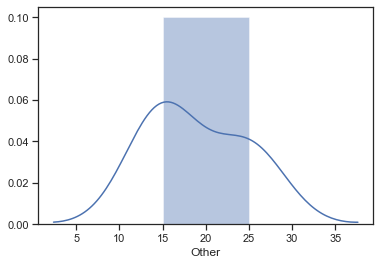

occurrenceyear
2014    3585
2015    3464
2016    3613
2017    3901
2018    3522
Name: Robbery, dtype: int64


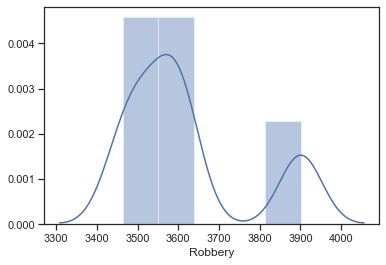

occurrenceyear
2014    27
2015    26
2016    41
2017    39
2018    51
Name: Shooting, dtype: int64


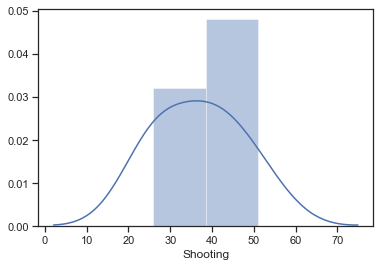

occurrenceyear
2014    16
2015    18
2016     9
2017    11
2018    20
Name: Stabbing, dtype: int64


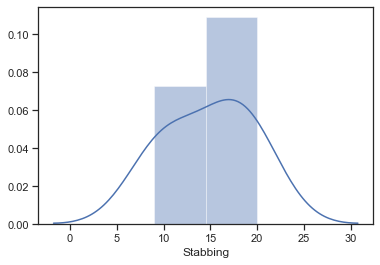

occurrenceyear
2014     994
2015    1019
2016    1012
2017    1149
2018    1141
Name: Theft Over, dtype: int64


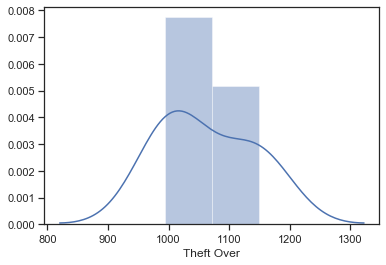

In [85]:
for i in range(0, mci_ct.shape[0]):
    print (mci_ct.iloc[i, 0:-1])
    sns.distplot(mci_ct.iloc[i, 0:-1])
   # mci_ct.iloc[i, 0:-1].hist(bins=5)
    plt.show()

From the table and distribution plots above we can see that there it is not a standard n distribution. 

Crosstab the major crime indicators and look at the correlation per type of crime. 

In [86]:
#Transpoded crosstab & find correlation
mci_ct_t =  pd.crosstab(mci_df.type, mci_df.occurrenceyear, margins=False).reindex()
mci_ct_t = mci_ct_t.T
type_correlation = mci_ct_t.corr()
type_correlation

type,Assault,Auto Theft,Break and Enter,Other,Robbery,Shooting,Stabbing,Theft Over
type,,,,,,,,
Assault,1.000000,0.299513,-0.218075,0.456443,0.447955,0.740583,-0.318584,0.745530
Auto Theft,0.299513,1.000000,0.782182,0.499696,-0.107950,0.763292,0.558208,0.679521
Break and Enter,-0.218075,0.782182,1.000000,-0.065068,-0.251301,0.199101,0.849350,0.411949
Other,0.456443,0.499696,-0.065068,1.000000,-0.267513,0.803685,-0.058790,0.163311
Robbery,0.447955,-0.107950,-0.251301,-0.267513,1.000000,0.173498,-0.660216,0.513035
Shooting,0.740583,0.763292,0.199101,0.803685,0.173498,1.000000,-0.026706,0.708246
Stabbing,-0.318584,0.558208,0.849350,-0.058790,-0.660216,-0.026706,1.000000,0.107389
Theft Over,0.745530,0.679521,0.411949,0.163311,0.513035,0.708246,0.107389,1.000000


## Heat map graph for the major crime indicators *** to be included in the ppt

(8.0, 0.0)

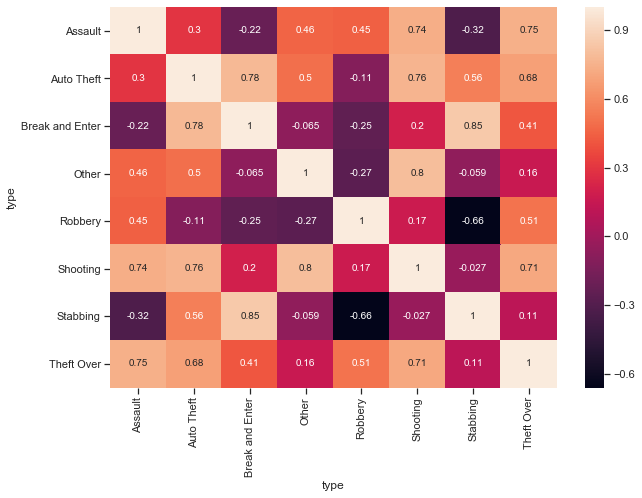

In [87]:
#Correlation heatmap
plt.figure(figsize=(10,7))
ax = sns.heatmap(type_correlation, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
 

Assault has high correlation with 
-	Shooting and
-	Theft over

Auto theft has high correlations with
-	Break and enter
-	Shooting
-	Theft over

### Annual MCI analysis

In [90]:
T_annual = pd.concat([pd.Series(mciYearly.index, name='Year'), 
                       pd.Series(mciYearly.values, name='Total cases')], axis=1).reset_index()
T_annual = T_annual.drop(columns=['index'])
T_annual

,Year,Total cases
0,2014,31686
1,2015,32341
2,2016,32826
3,2017,34522
4,2018,35478


Text(0.5, 1.0, 'Annual MCI')

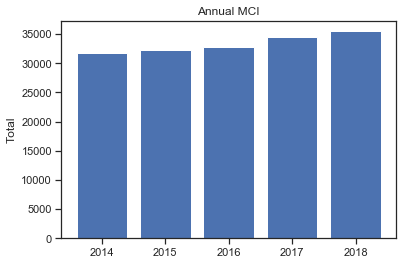

In [102]:
plt.bar('Year', height='Total cases', width=0.8, align='center', data=T_annual)
plt.ylabel('Total')
plt.title('Annual MCI')

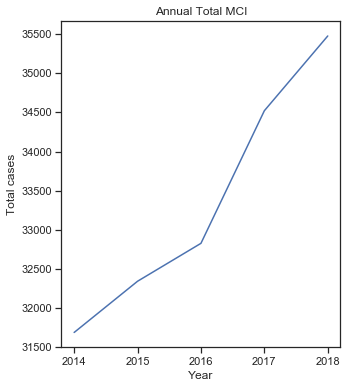

In [103]:
fig, ax = plt.subplots(figsize=(5,6))
sns.lineplot(x='Year', y='Total cases', data=T_annual, color='b')
ax.set_title('Annual Total MCI')
plt.show()

The total number of crimes is going up in Toronto, however, before going to conclusions lets look at another perspectives. 

## Year to year MCI by Neighbourhood

### Top 10, most dangerous neighbourhoods

In [104]:
bad_hood_ct = pd.crosstab(mci_df.neighbourhood, mci_df.occurrenceyear, margins=True)
bad_hood_ct.sort_values("All", axis = 0, ascending = False,
                 inplace = True) 
bad_hood_ct.head(11)

occurrenceyear,2014,2015,2016,2017,2018,All
neighbourhood,,,,,,
All,31686,32341,32826,34522,35478,166853
Church-Yonge Corridor (75),1020,1112,1147,1460,1555,6294
Waterfront Communities-The Island (77),943,1053,1131,1247,1267,5641
West Humber-Clairville (1),832,773,817,865,1035,4322
Moss Park (73),622,638,729,696,918,3603
Bay Street Corridor (76),581,689,671,810,806,3557
Kensington-Chinatown (78),564,601,580,696,818,3259
Woburn (137),623,671,555,693,607,3149
York University Heights (27),569,662,644,639,608,3122


### Mapping top 5, most dangerous neighbourhoods by year

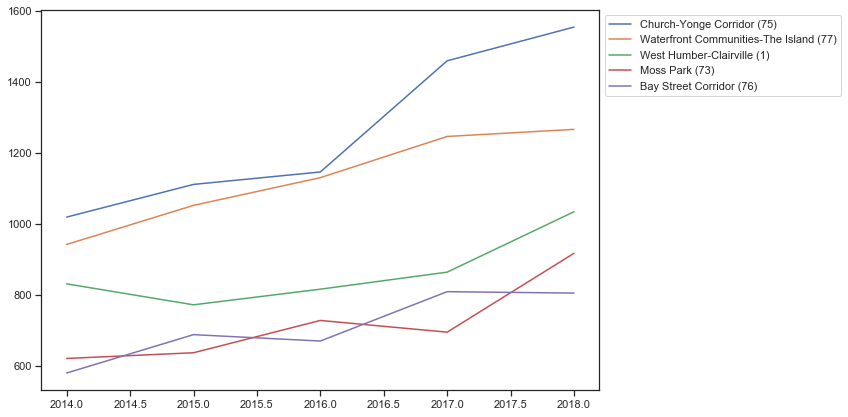

In [105]:
top5dangerous = bad_hood_ct.iloc[1:6,:5].T
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(top5dangerous)
ax.legend(top5dangerous.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

### Top 10, safest neighbourhoods 

In [106]:
bad_hood_ct.tail(10)

occurrenceyear,2014,2015,2016,2017,2018,All
neighbourhood,,,,,,
Princess-Rosethorn (10),75,61,95,70,63,364
Forest Hill South (101),68,55,47,106,82,358
Caledonia-Fairbank (109),71,62,68,67,56,324
Yonge-Eglinton (100),67,58,63,67,68,323
Centennial Scarborough (133),62,50,70,76,52,310
Broadview North (57),62,64,71,53,50,300
Markland Wood (12),78,47,59,52,56,292
Yonge-St.Clair (97),57,46,51,39,41,234
Lambton Baby Point (114),34,49,30,33,44,190


### map of top 5 safest neighbourhood

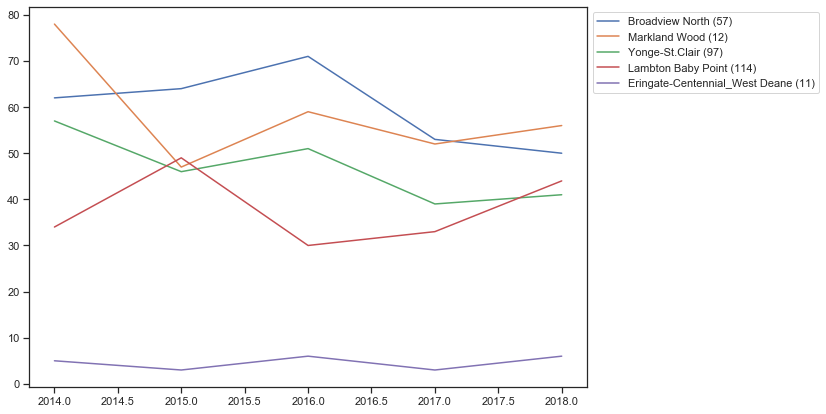

In [107]:
top5safest = bad_hood_ct.iloc[-5:,:5].T
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(top5safest)
ax.legend(top5safest.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

### interpretation
The top 5 most dangerous neighborhoods  analysis shows that the total number of crimes is going up fast over the years, 
there is also a slight growth in total number of crimes for the safest neighborhoods too 

# Mapping MCI

In [108]:
import geopandas as gpd
import descartes  as dts
sns.set(style="darkgrid")

In [109]:
#group data by Neighbourhood and count 
df_gp = mci_df.groupby(['Hood_ID','neighbourhood']).count()[['type']]
mci_df_gp= df_gp.reset_index()
mci_df_gp

,Hood_ID,neighbourhood,type
0,1,West Humber-Clairville (1),4322
1,2,Mount Olive-Silverstone-Jamestown (2),2250
2,3,Thistletown-Beaumond Heights (3),612
3,4,Rexdale-Kipling (4),694
4,5,Elms-Old Rexdale (5),581
...,...,...,...
136,136,West Hill (136),2842
137,137,Woburn (137),3149
138,138,Eglinton East (138),1797
139,139,Scarborough Village (139),1237


Lattest Shape file from  https://open.toronto.ca/dataset/neighbourhoods/ accessed on  03/02/2020

In [110]:
location = 'Neighbourhoods.shp'
hoods = gpd.read_file(location)
hoods.sample(3)

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry
112,3613,25886733,25926774,49885,5,5,Elms-Old Rexdale (5),Elms-Old Rexdale (5),None,None,-79.548983,43.721519,16493297,5.616463e+06,12955.634989,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."
29,3530,25886330,25926691,49885,54,54,O'Connor-Parkview (54),O'Connor-Parkview (54),None,None,-79.312228,43.706800,16491969,9.338496e+06,15115.715645,"POLYGON ((-79.33542 43.70320, -79.33529 43.703..."
25,3526,25886566,25926687,49885,36,36,Newtonbrook West (36),Newtonbrook West (36),None,None,-79.431422,43.785830,16491905,9.015928e+06,11964.296371,"POLYGON ((-79.44576 43.79241, -79.44335 43.792..."


In [111]:
merged = hoods.set_index('FIELD_7').join(mci_df_gp.set_index('neighbourhood'))
merged = merged.reset_index()
merged[['FIELD_7', 'FIELD_11', 'FIELD_12', 'geometry', 'type']].sample(5)
merged.head(3)

,FIELD_7,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry,Hood_ID,type
0,Wychwood (94),3501,25886861,25926662,49885,94,94,Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",94,622
1,Yonge-Eglinton (100),3502,25886820,25926663,49885,100,100,Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",100,323
2,Yonge-St.Clair (97),3503,25886834,25926664,49885,97,97,Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",97,234


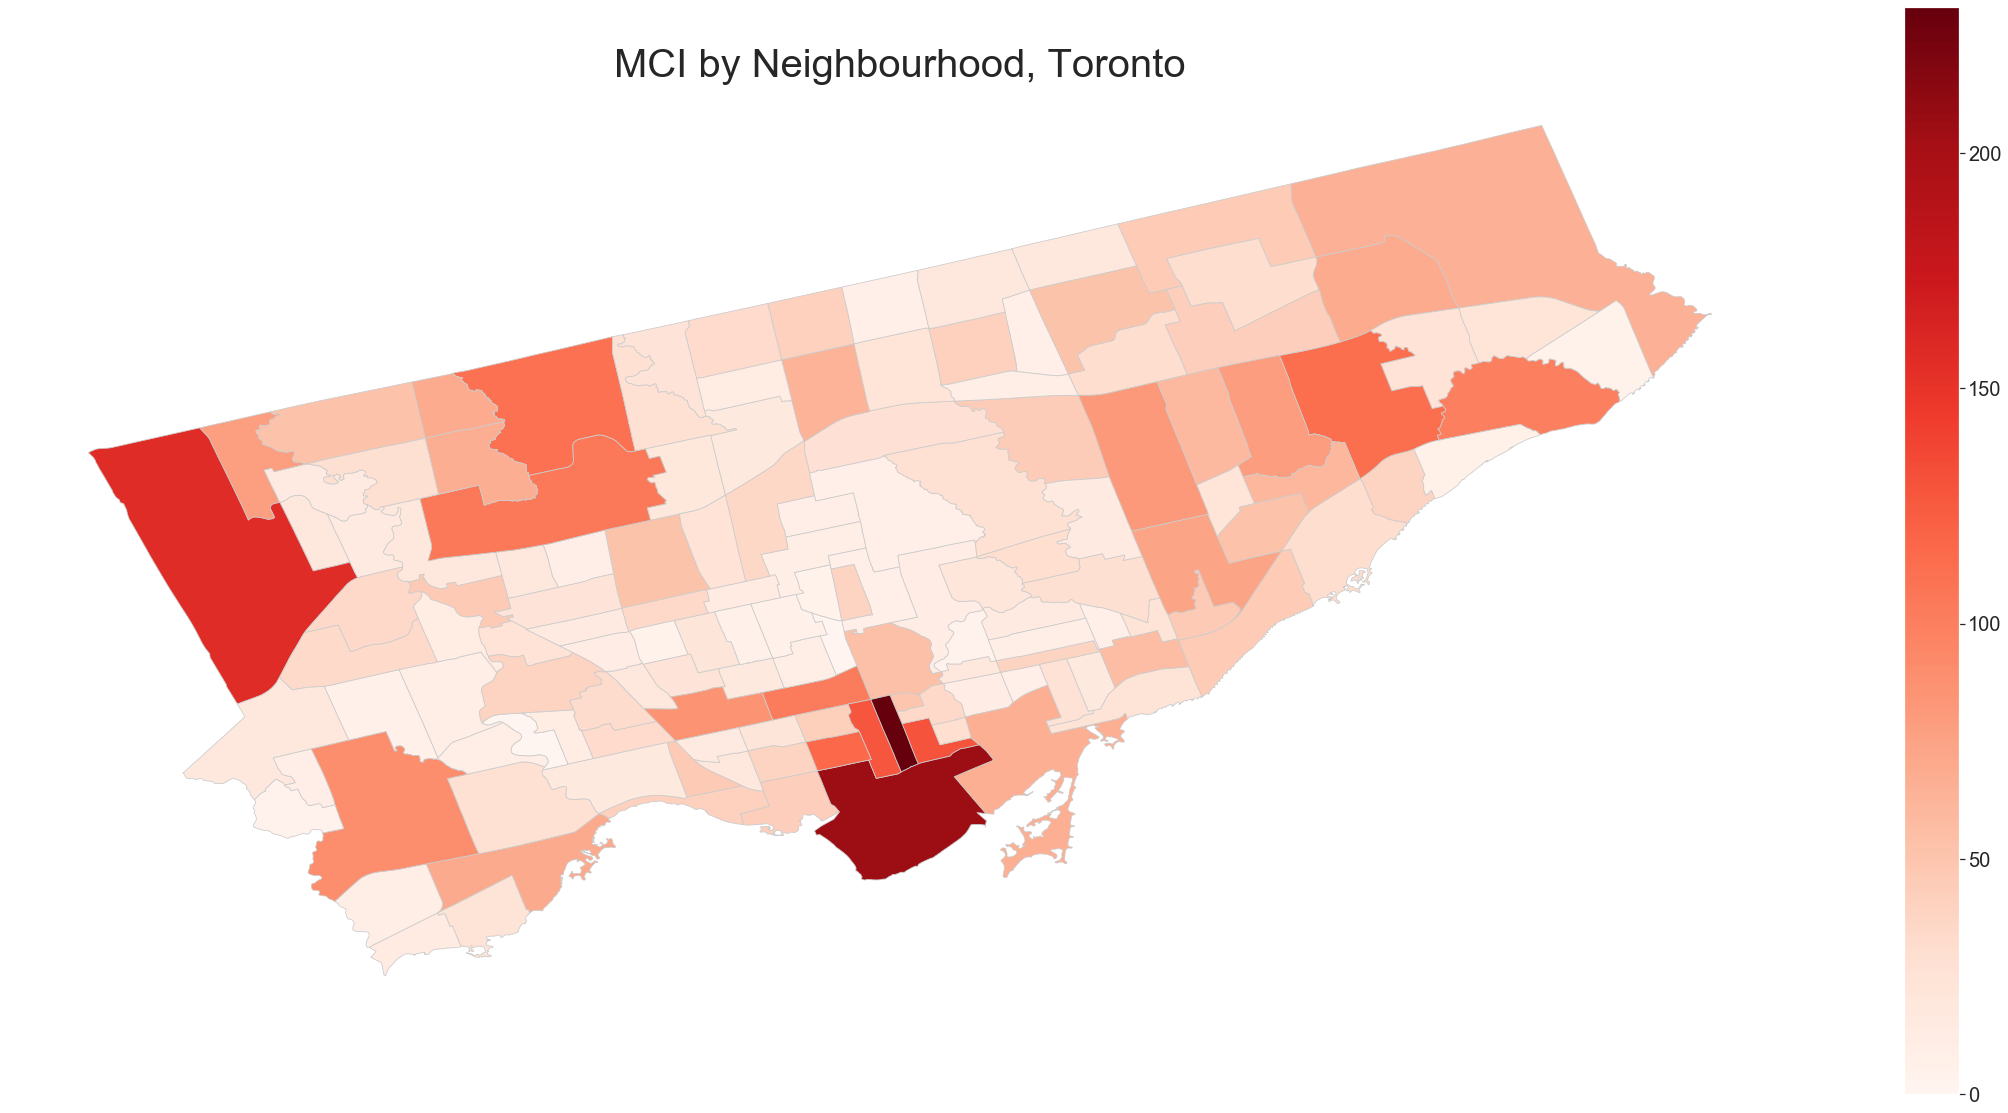

In [112]:
# try to include interactive link with tableau
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('MCI by Neighbourhood, Toronto', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Reds'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('type', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

# Neighborhoods by Income

Import income file


In [115]:
Nhood_income = pd.read_csv('Nhood_income.csv')


In [116]:
#convert to lower case for for mergin
Nhood_income['Neighborhood']=Nhood_income['Neighborhood'].str.lower()
Nhood_income.head(2)

,Neighborhood,HoodAveIncome,HoodID
0,city of toronto,52268,0
1,agincourt north,30414,129


In [119]:
Nhood_income['HoodID'] = Nhood_income['HoodID'].astype('Int32') 

In [120]:
#clrear neighbourhood numbers, because other table doesnt have numbers from merged data frame
merged['neighbourhood'] = merged['FIELD_8'].str.replace(' \(.+\)', '').str.lower()

In [123]:
merged['HoodID'] = merged['Hood_ID'].astype('Int32') 
merged.drop(["Hood_ID"], axis = 1, inplace = True)  
merged.head(2)

,FIELD_7,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry,type,neighbourhood,HoodID
0,Wychwood (94),3501,25886861,25926662,49885,94,94,Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",622,wychwood,94
1,Yonge-Eglinton (100),3502,25886820,25926663,49885,100,100,Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",323,yonge-eglinton,100


In [124]:
#add income to table
merged_income = merged.set_index('HoodID').join(Nhood_income.set_index('HoodID'))
merged_income = merged_income.reset_index()
merged_income.head(3)

,HoodID,FIELD_7,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_9,...,FIELD_11,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry,type,neighbourhood,Neighborhood,HoodAveIncome
0,94,Wychwood (94),3501,25886861,25926662,49885,94,94,Wychwood (94),None,...,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",622,wychwood,wychwood,54460
1,100,Yonge-Eglinton (100),3502,25886820,25926663,49885,100,100,Yonge-Eglinton (100),None,...,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",323,yonge-eglinton,yonge-eglinton,89330
2,97,Yonge-St.Clair (97),3503,25886834,25926664,49885,97,97,Yonge-St.Clair (97),None,...,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680...",234,yonge-st.clair,yonge-st.clair,114174


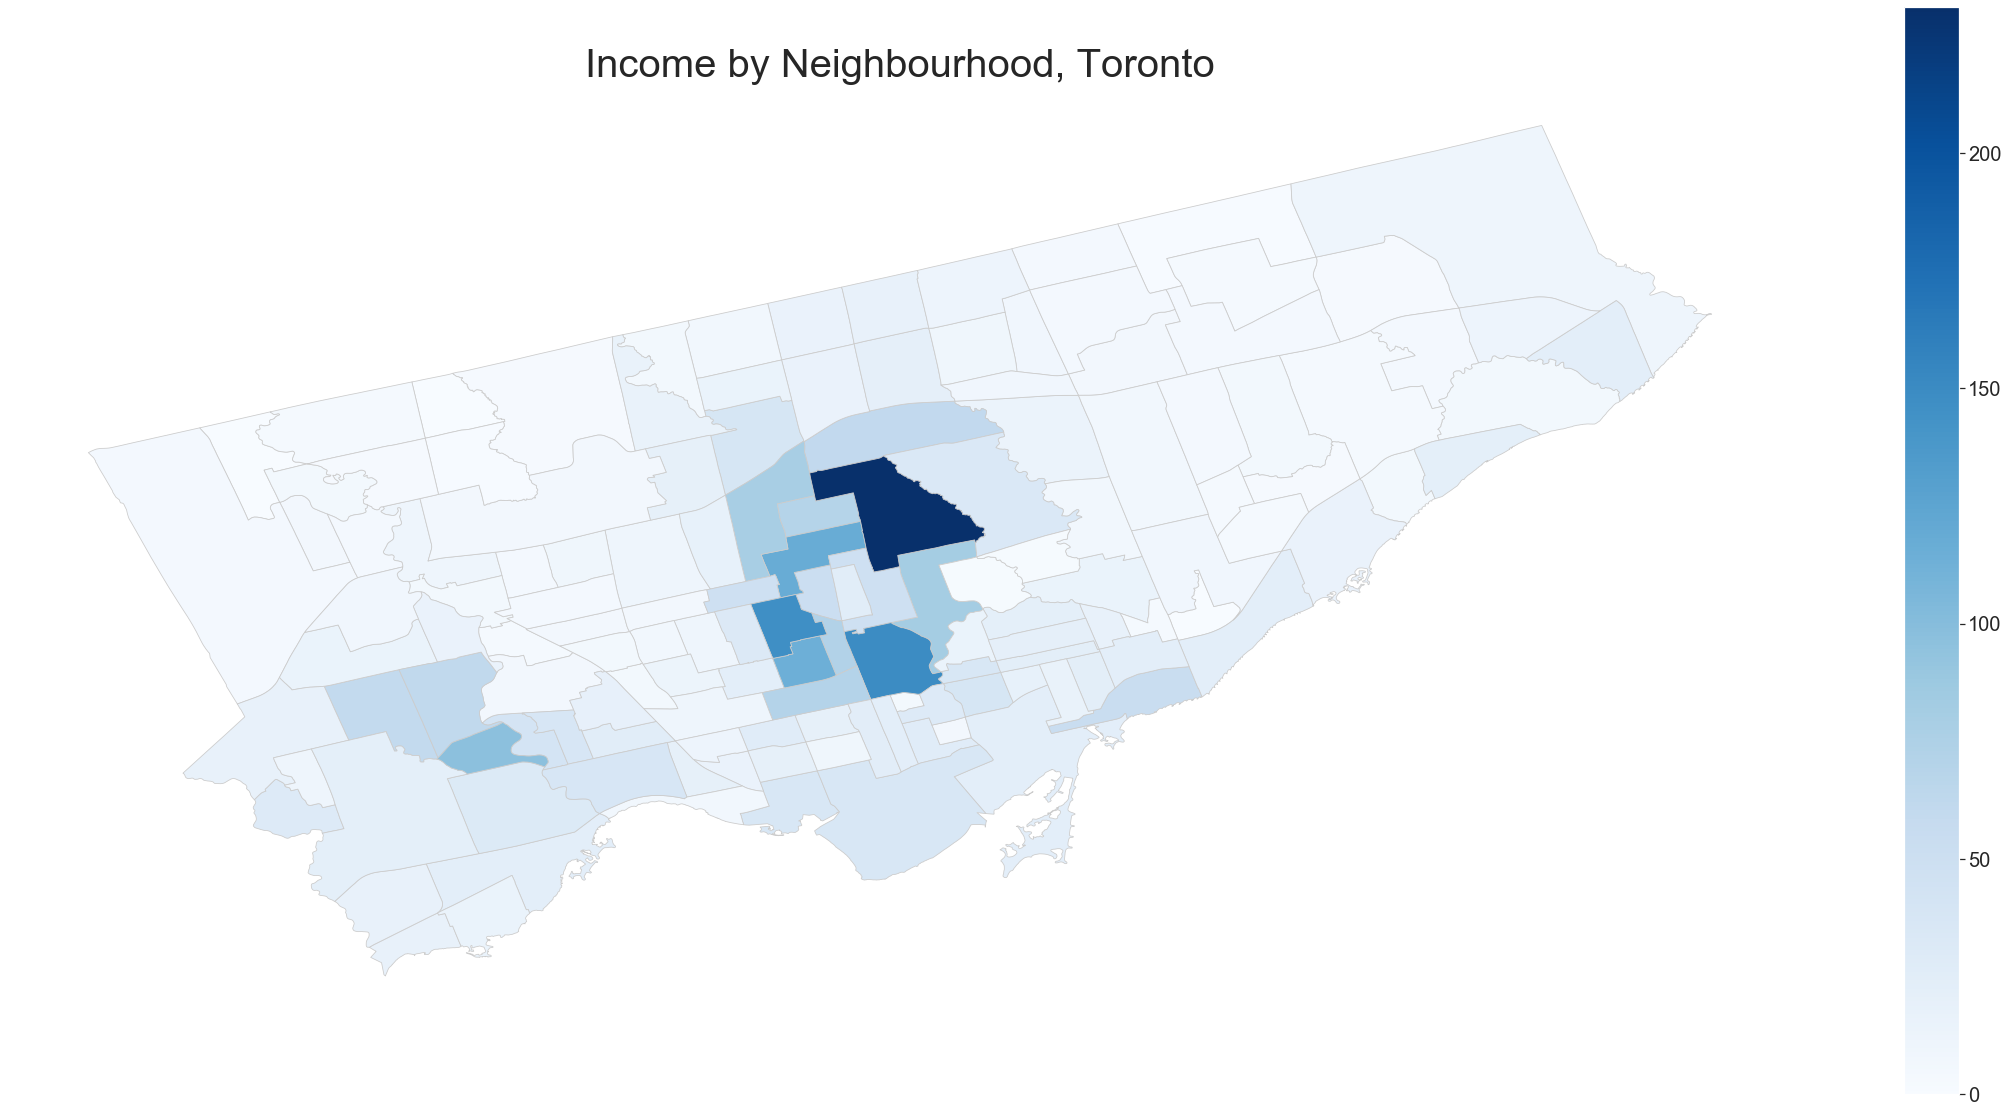

In [125]:
#plot a map
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Income by Neighbourhood, Toronto', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Blues'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged_income.plot('HoodAveIncome', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

In [129]:
#Nhood_income["HoodAveIncome"] = Nhood_income["HoodAveIncome"].astype('Int64')
print('Correlation of average neighbourhood income with the main crime indicators is :')
merged_income['type'].corr(merged_income['HoodAveIncome']) 

Correlation of average neighbourhood income with the main crime indicators is :


-0.17277693479292142

In [130]:
pg.corr(x=merged_income['type'], y=merged_income['HoodAveIncome'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,140,-0.173,"[-0.33, -0.01]",0.03,0.016,0.041214,0.831,0.536


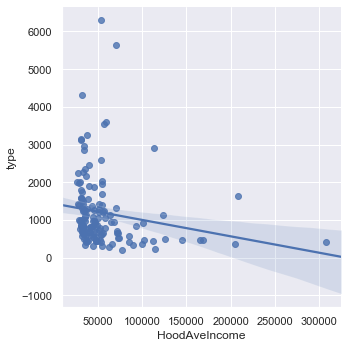

In [131]:
sns.lmplot(data=merged_income, x='HoodAveIncome', y='type')

With neighborhood income going up the MCI is going down. The p-val =0.04 < 0.05 therefore, the confidence in correlation is high

## Crime to Income ratio

I will add crime to income ration. It will highlight neighborhoods for hi ratios for example , if number of crime is high but income is high, the ration will be also high. Also , if crime is low and income is low then ration will be also higher. 

In [133]:
merged_income['Ratio'] = 100 * merged_income['type'] / merged_income['HoodAveIncome']
merged_income.head(2)

,HoodID,FIELD_7,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_8,FIELD_9,...,FIELD_12,FIELD_13,FIELD_14,FIELD_15,geometry,type,neighbourhood,Neighborhood,HoodAveIncome,Ratio
0,94,Wychwood (94),3501,25886861,25926662,49885,94,94,Wychwood (94),None,...,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680...",622,wychwood,wychwood,54460,1.142123
1,100,Yonge-Eglinton (100),3502,25886820,25926663,49885,100,100,Yonge-Eglinton (100),None,...,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704...",323,yonge-eglinton,yonge-eglinton,89330,0.361581


In [134]:
merged_income.sort_values("Ratio", axis = 0, ascending = False,
                 inplace = True)


In [135]:
# top ten
merged_income[['FIELD_7','type','HoodAveIncome','Ratio']].head(10)

,FIELD_7,type,HoodAveIncome,Ratio
63,West Humber-Clairville (1),4322,31771,13.603601
97,Church-Yonge Corridor (75),6294,53583,11.746263
3,York University Heights (27),3122,29958,10.421256
71,Woburn (137),3149,30878,10.198199
136,Kensington-Chinatown (78),3259,37422,8.708781
107,Downsview-Roding-CFB (26),2959,34168,8.660150
62,West Hill (136),2842,33323,8.528644
20,Mount Olive-Silverstone-Jamestown (2),2250,26548,8.475215
61,Waterfront Communities-The Island (77),5641,70600,7.990085
87,Black Creek (24),2003,25989,7.707107


In [136]:
# bottom ten
merged_income[['FIELD_7','type','HoodAveIncome','Ratio']].tail(10)

,FIELD_7,type,HoodAveIncome,Ratio
7,Lawrence Park North (105),443,111730,0.396492
38,Princess-Rosethorn (10),364,99055,0.367473
1,Yonge-Eglinton (100),323,89330,0.361581
138,Kingsway South (15),453,144642,0.313187
95,Casa Loma (96),456,165047,0.276285
8,Lawrence Park South (103),467,169203,0.276000
5,Lambton Baby Point (114),190,76629,0.247948
2,Yonge-St.Clair (97),234,114174,0.204950
118,Forest Hill South (101),358,204521,0.175043
90,Bridle Path-Sunnybrook-York Mills (41),418,308010,0.135710


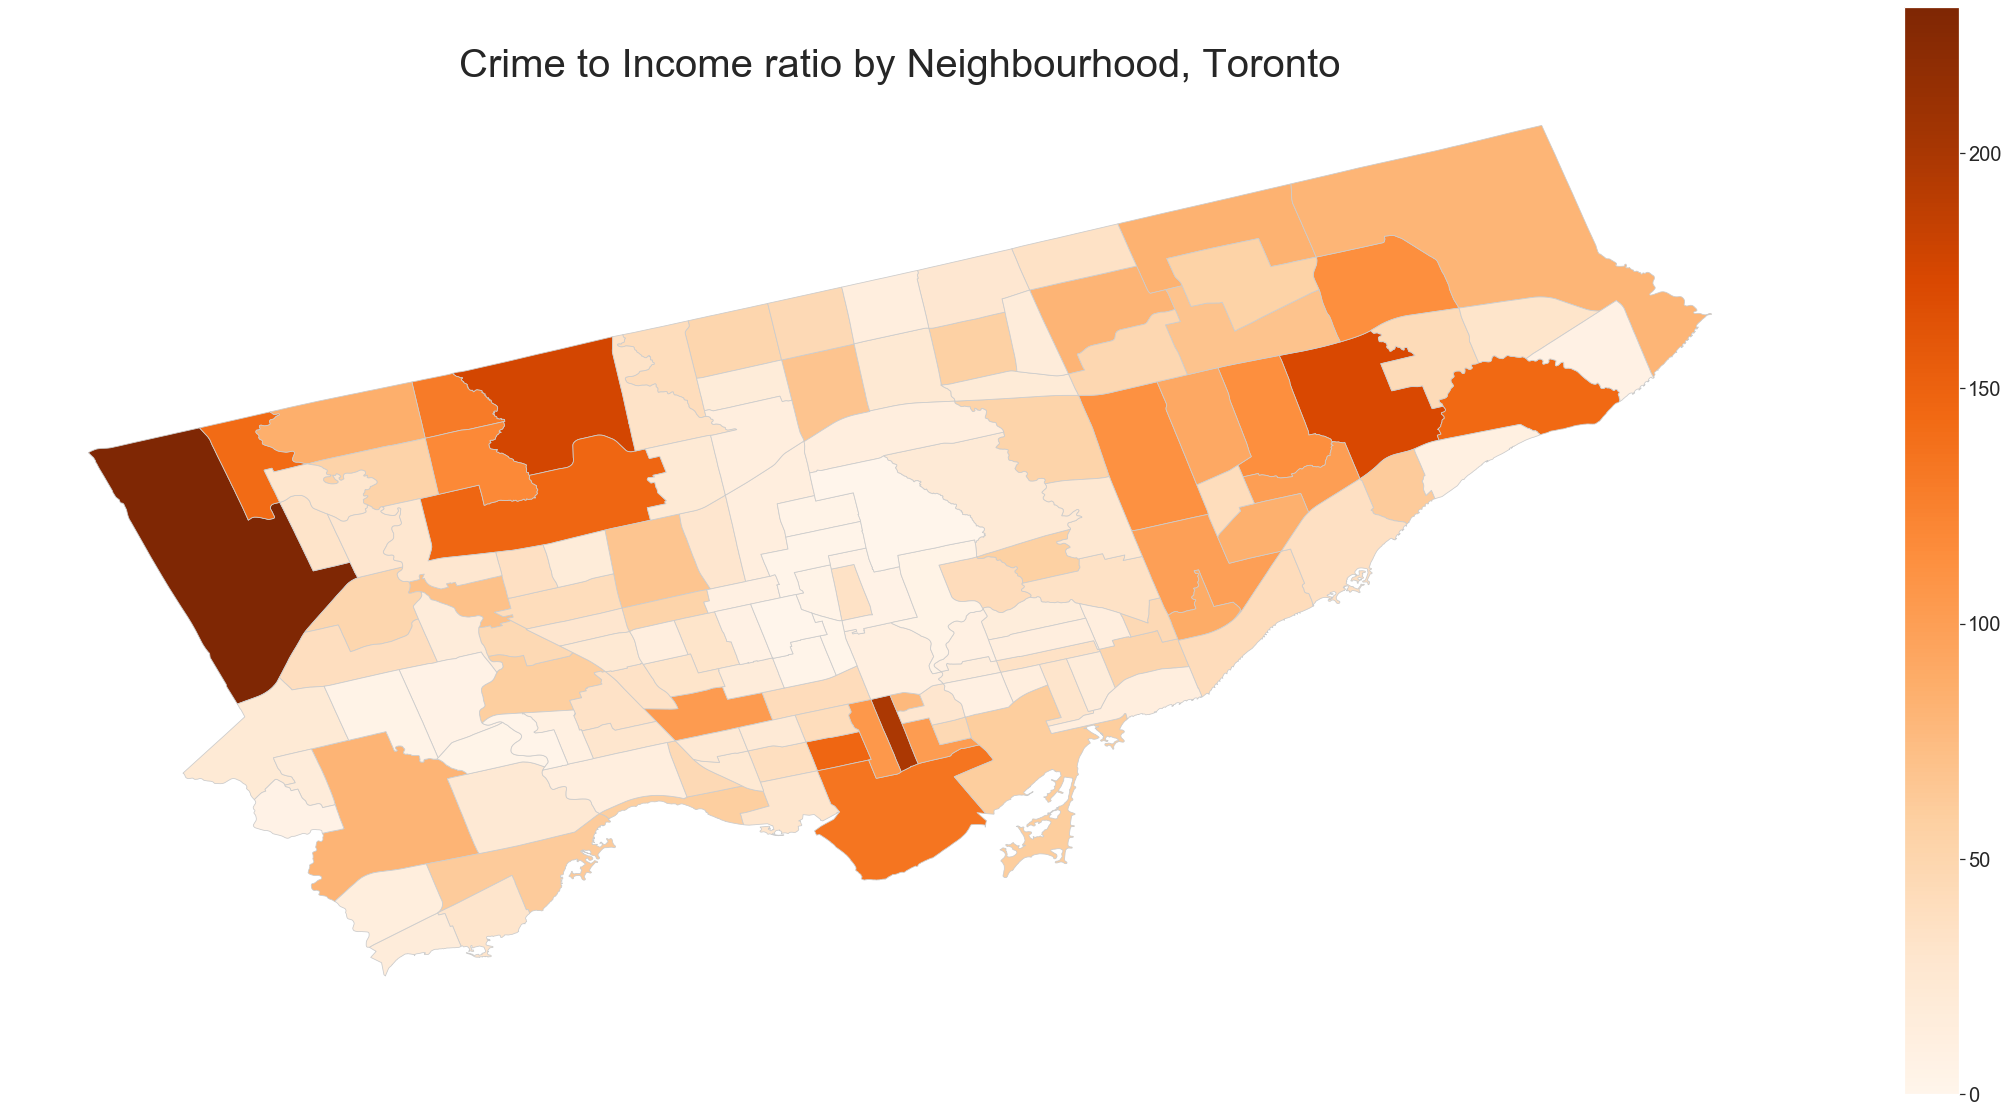

In [137]:
#plot a map
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Crime to Income ratio by Neighbourhood, Toronto', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged_income.plot('Ratio', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

This ratio did not change picture at all. It just shows that low income neighborhoods have the most crimes. 

However, it highlighted additional neighborhoods with high crime/income ratio
 - York University Heights (27)
 - Woburn (137)
 - Kensington-Chinatown (78)
 

In addition, <b>Church-Yonge Corridor (75)</b> stands out from the rest of neighborhoods. The income is about 1.7 times higher than all other high MCI hoods, however, the MCI is the highest amongst all Toronto neighborhoods 

# Population, Unemployment Rate, Average Income 

## Loading and cleaning

### Population data

In [140]:
#prepare population data
population = pd.read_csv('pop_estimate.csv')
#population

In [143]:
#plt.bar('Year', height='Population', width=0.8, align='center', data=population)
population.Year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [144]:
population = population[(population['Year'] >=2014) & (population['Year'] <=2018)]
population = population.reset_index(drop=True)
population

,Year,Population
0,2014,2684967
1,2015,2708269
2,2016,2731571
3,2017,2930000
4,2018,3006000


In [150]:
#add population to annual cases
T_annual_percap = T_annual
T_annual_percap = T_annual_percap.join(population.Population)
T_annual_percap

,Year,Total cases,Population
0,2014,31686,2684967
1,2015,32341,2708269
2,2016,32826,2731571
3,2017,34522,2930000
4,2018,35478,3006000


In [153]:
T_annual_percap['type']=T_annual_percap['Total cases']

Since per capita value is small, it would be useful to scale population down by a factor of 100. This additional value will be a better visual when plotted. 

In [154]:
#number of homicide per 1,000 and  in percent
T_annual_percap['PerCap%'] = round(100*T_annual_percap.type/T_annual_percap.Population,4)
#T_annual_percap['PerCap1K%'] = round(100*T_annual_percap.type/T_annual_percap.Population,2)
T_annual_percap['Pop100'] = round(T_annual_percap.Population/100,2)
T_annual_percap

,Year,Total cases,Population,type,PerCap%,Pop100
0,2014,31686,2684967,31686,1.1801,26849.67
1,2015,32341,2708269,32341,1.1942,27082.69
2,2016,32826,2731571,32826,1.2017,27315.71
3,2017,34522,2930000,34522,1.1782,29300.00
4,2018,35478,3006000,35478,1.1802,30060.00


## Unemployment rate

In [156]:
#prepare unemployment rate
unemployment = pd.read_csv('unemployment_ontario.csv')


In [157]:
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
Year         15 non-null int64
UnempRate    15 non-null float64
dtypes: float64(1), int64(1)
memory usage: 368.0 bytes


<BarContainer object of 15 artists>

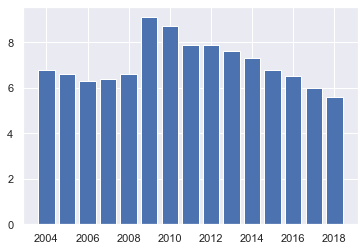

In [158]:
plt.bar('Year', height='UnempRate', width=0.8, align='center', data=unemployment)

In [159]:
#remove unused years 
unemployment = unemployment[(unemployment['Year'] >=2014) & (unemployment['Year']<=2018)]
unemployment = unemployment.reset_index(drop=True)
unemployment

,Year,UnempRate
0,2014,7.3
1,2015,6.8
2,2016,6.5
3,2017,6.0
4,2018,5.6


In [160]:
T_annual_percap = T_annual_percap.join(unemployment.UnempRate)
T_annual_percap

,Year,Total cases,Population,type,PerCap%,Pop100,UnempRate
0,2014,31686,2684967,31686,1.1801,26849.67,7.3
1,2015,32341,2708269,32341,1.1942,27082.69,6.8
2,2016,32826,2731571,32826,1.2017,27315.71,6.5
3,2017,34522,2930000,34522,1.1782,29300.00,6.0
4,2018,35478,3006000,35478,1.1802,30060.00,5.6


# Average Income

In [162]:
#Load and prepare average income data
aveIncome = pd.read_csv('average_income.csv')

<BarContainer object of 15 artists>

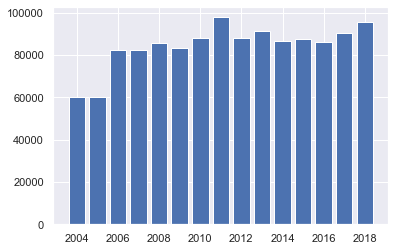

In [163]:
plt.bar('Year', height='AverageIncome', width=0.8, align='center', data=aveIncome)

In [164]:
#remove unused years 
aveIncome = aveIncome[(aveIncome['Year'] >=2014) & (aveIncome['Year']<=2018)]
aveIncome = aveIncome.reset_index(drop=True)
aveIncome

,Year,AverageIncome
0,2014,86700
1,2015,87700
2,2016,86400
3,2017,90600
4,2018,95600


In [165]:
T_annual_percap = T_annual_percap.join(aveIncome.AverageIncome)
T_annual_percap

,Year,Total cases,Population,type,PerCap%,Pop100,UnempRate,AverageIncome
0,2014,31686,2684967,31686,1.1801,26849.67,7.3,86700
1,2015,32341,2708269,32341,1.1942,27082.69,6.8,87700
2,2016,32826,2731571,32826,1.2017,27315.71,6.5,86400
3,2017,34522,2930000,34522,1.1782,29300.00,6.0,90600
4,2018,35478,3006000,35478,1.1802,30060.00,5.6,95600


## Correlation between main crime indicators and per capita with Population, Unemployment Rate, Average Income

### Correlation main crime indicators with Population

In [166]:
print('Correlation MCI per Capita and Population')
T_annual_percap['Population'].corr(T_annual_percap['type']) 

Correlation MCI per Capita and Population


0.9886166697933653

In [169]:
pg.corr(x=T_annual_percap['Population'], y=T_annual_percap['type'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,5,0.989,"[0.83, 1.0]",0.977,0.955,0.001455,14.608,0.971


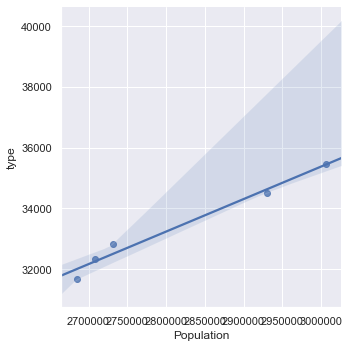

In [171]:
sns.lmplot(data=T_annual_percap, x='Population', y='type')

Correlation of MCI with Population is 0.988, with p-val =0.001 <0.05 , this very strong confidence in correlation. 
It is expected result, when population goes up, the crime goes up as well.


### Correlation main crime indicators with Unemployment

In [172]:
print('Correlation MCI per Capita and Unemployment')
T_annual_percap['UnempRate'].corr(T_annual_percap['PerCap%']) 

Correlation MCI per Capita and Unemployment


0.25537983228472094

In [173]:
pg.corr(x=T_annual_percap['UnempRate'], y=T_annual_percap['PerCap%'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,5,0.255,"[-0.81, 0.93]",0.065,-0.87,0.67841,0.576,0.074


the relationship is not significant, we dont have enough evidence

In [174]:
print('Correlation MCI and Unemployment')
T_annual_percap['UnempRate'].corr(T_annual_percap['type']) 

Correlation MCI and Unemployment


-0.9827531333312208

In [175]:
pg.corr(x=T_annual_percap['UnempRate'], y=T_annual_percap['type'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,5,-0.983,"[-1.0, -0.76]",0.966,0.932,0.002712,11.023,0.944


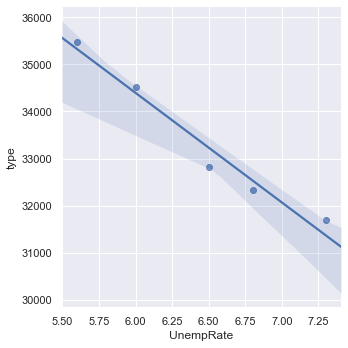

In [177]:
sns.lmplot(data=T_annual_percap, x='UnempRate', y='type')

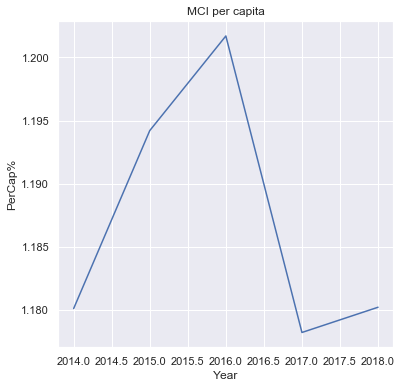

In [178]:
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x='Year', y='PerCap%', data=T_annual_percap, color='b')
ax.set_title('MCI per capita')
plt.show()

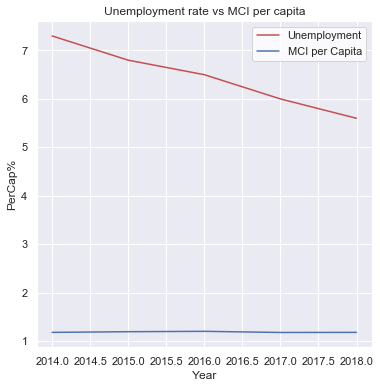

In [179]:
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x='Year', y='UnempRate', data=T_annual_percap, color='r')
sns.lineplot(x='Year', y='PerCap%', data=T_annual_percap, color='b')
ax.legend(['Unemployment', 'MCI per Capita'], facecolor='w')
ax.set_title('Unemployment rate vs MCI per capita')
plt.show()

Correlation of MCI with Unemployment rate is -0.98 and p-val = 0.03 so the confidence in correlation is high. This is unexpected result. One would expect that if unemployment goes down, then crime will go down as well. 


Looking at the graph per capita MCI jumped up in 2016 then lowered in 2017. However, plotting MCI per capita against Unemployment rate, MCI per capita looks flat when scaled. That is because the “jump” is only 0.02%. 

Let’s look at average income and gain some insights there. 


## Correlation MCI with Income

In [180]:
print('Correlation MCI per Capita and Average Income')
T_annual_percap['AverageIncome'].corr(T_annual_percap['PerCap%']) 

Correlation MCI per Capita and Average Income


-0.5615136975934893

In [181]:
pg.corr(x=T_annual_percap['AverageIncome'], y=T_annual_percap['PerCap%'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,5,-0.562,"[-0.97, 0.64]",0.315,-0.369,0.324643,0.813,0.176


In [182]:
print('Correlation MCI and Average Income')
T_annual_percap['AverageIncome'].corr(T_annual_percap['type']) 

Correlation MCI and Average Income


0.922688545267317

In [183]:
pg.corr(x=T_annual_percap['AverageIncome'], y=T_annual_percap['type'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,5,0.923,"[0.22, 0.99]",0.851,0.703,0.025503,3.546,0.692


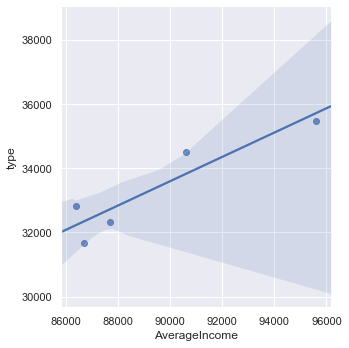

In [184]:
sns.lmplot(data=T_annual_percap, x='AverageIncome', y='type')

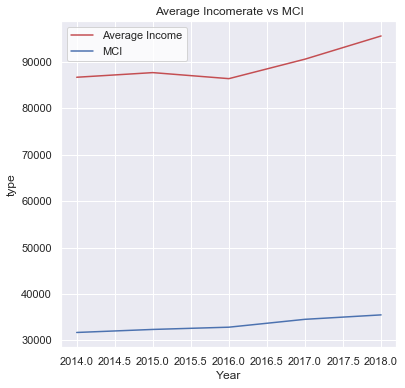

In [187]:
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x='Year', y='AverageIncome', data=T_annual_percap, color='r')
sns.lineplot(x='Year', y='type', data=T_annual_percap, color='b')
ax.legend(['Average Income', 'MCI'], facecolor='w')
ax.set_title('Average Incomerate vs MCI')
plt.show()

Correlation of MCI per capita with Average income is -0.56 and p-val = 0.3 >0.05. Negative correlation is expected but the confidence in correlation is low. 

Now looking at correlation of MCI with Average income we find correlation is equal to 0.92 with p-val = 0.03 <0.05 this confidence is high. 

This again is unexpected result. It looks like when unemployment goes down and average income goes up so crime in the city goes. 

Its interesting to note, that crime per capita fluctuated a bit but the change is very small, it is staying constant, and low at about 1.8%, therefore per capita stats hitting at expected correlation, but the confidence in those correlations is low. 

Ardavan Eizadirad suggested in the research of crime in Toronto area that one of the roots of crime is poverty. 

I  think that the correlation is accurately calculated, but not does not represent the complete picture. Perhaps, if I look into age group, income and unemployment rate of people committing crime, then it could lead to similar conclusions. However, right now data does not support expected  prediction. 



# Linear regression MCI

In [188]:
#Linear regression function
def LinearPredict(x,y,years):
    #reshape data
    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))
    #build model and train
    model = LinearRegression()
    model.fit(x, y)
    #evaluate error
    r_sq = model.score(x, y)
    #make predictions
    y_pred = model.predict(years)
    
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)
    print('coefficient of determination:', r_sq)
    print('Prediction of homicides in', years, 'will be', np.round(y_pred,0))    
    
    return model.coef_, model.intercept_, y_pred


In [196]:
#Years to predict
yearsToPredict = np.array([[2019],[2020]])

In [197]:
T_annual['type']=T_annual['Total cases']

In [198]:
#get MCI data
x = T_annual['Year'].values
y = T_annual['type'].values
m,b, pred = LinearPredict(x,y,yearsToPredict)
#print("data", m,b,pred)

intercept: [-1935253.4]
slope: [[976.5]]
coefficient of determination: 0.9572473011622703
Prediction of homicides in [[2019]
 [2020]] will be [[36300.]
 [37277.]]


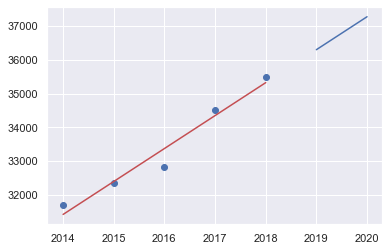

In [200]:
#Plot Results
plt.scatter(T_annual_percap['Year'], T_annual_percap['type'], marker='o')
y =  m[0]*T_annual_percap['Year']+b
x = T_annual_percap['Year']

plt.plot(x, y, '-r')
plt.plot(yearsToPredict,pred,'-b')    

From the plot above it is clear that the linear regression fits very well. 

However, still better to try polynomial regression of 2nd and 3rd order. 

# Polynomial Regression MCI

## Polynomial regression of 2nd order

In [201]:
# Reshape Data
x = (T_annual['Year'].values).reshape(-1, 1)
y = T_annual['type'].values

#build and train model
poly_reg = PolynomialFeatures(degree=2)
x_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(x_poly, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [202]:
#make prediction
pred = pol_reg.predict(poly_reg.fit_transform(yearsToPredict))

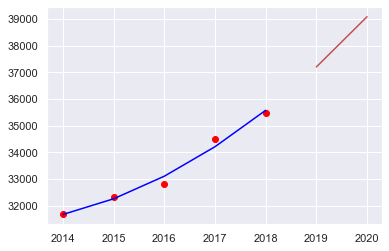

Polynomical Predict for  [[2019]
 [2020]] [37207. 39090.]


In [203]:
# Visualizing the Polymonial Regression results

plt.scatter(x, y, color='red')
plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='blue')  
plt.plot(yearsToPredict,pred,'-r')
plt.show()

print('Polynomical Predict for ', yearsToPredict , np.round(pred,0))

From the plot above it is clear 2nd degree polynomial regression fits even better than linear. It seems to me a little bit more aggressive than linear, and seems over-fit. I lean towards using linear regression. 

## Polynomial regression of 3nd order

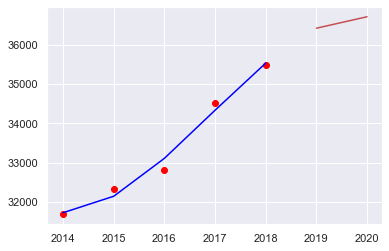

Polynomical Predict for  [[2019]
 [2020]] [36416.78863525 36708.46148682]


In [204]:
#build model
poly_reg = PolynomialFeatures(degree=3)
x_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
#train
pol_reg.fit(x_poly, y)
#predict 
pred = pol_reg.predict(poly_reg.fit_transform(yearsToPredict))
# Visualizing the Polymonial Regression results
plt.scatter(x, y, color='red')
plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='blue')  
plt.plot(yearsToPredict,pred,'-r')
plt.show()

print('Polynomical Predict for ', yearsToPredict , pred)

It seems that 3rd order polynomial regression also over fitted. It softens predictions for 2019 and 2020. 

I think, my chose of model in this case, is linear regression. 

## Support Vector Machine

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.


In [205]:
from sklearn import svm

In [206]:
x = (T_annual['Year'].values).reshape((-1, 1))
y = (T_annual['type'].values)
yearsToPredict

array([[2019],
       [2020]])

In [207]:
clf = svm.SVR(gamma='auto')
clf.fit(x,y)


resSVR = clf.predict(yearsToPredict)

resSvc_df =pd.DataFrame({'Predict': resSVR[:]})
resSvc_df

,Predict
0,32826.386195
1,32826.018439


The results for various models are:

    Linear regression - [2019 : 36300], [2020 : 37277]
    2nd order polynomial -  [2019 : 37207], [2020 : 39090]
    3rd order polynomial - [2019 : 36411], [2020 : 36702]
    Support vector machine -[2019 : 32826], [2020 : 32826]


It doesn’t seem that crime will be going down. I think that 2nd order polynomial fits data better than linear, therefore my chose is 2nd order polynomial regression. 

# Regression models per type of crime

Lets build regression models and make prediction for each crime group. 

In [209]:
#print dataset again
mci_ct = mci_ct.iloc[:, :-1]
mci_ct

occurrenceyear,2014,2015,2016,2017,2018
type,,,,,
Assault,16375,17705,18475,18973,18617
Auto Theft,3496,3195,3264,3558,4617
Break and Enter,7178,6899,6387,6876,7485
Other,15,15,25,15,25
Robbery,3585,3464,3613,3901,3522
Shooting,27,26,41,39,51
Stabbing,16,18,9,11,20
Theft Over,994,1019,1012,1149,1141


## Linear Regression

In [210]:
def LinearRegGroup(x,y,name):
    yearsToPredict = np.array([[2019],[2020]])
    
    x=x.reshape((-1,1))
    y=y.reshape((-1,1))
    
    model = LinearRegression()
    model.fit(x, y)
    #evaluate error
    r_sq = model.score(x, y)
    #make predictions
    y_pred = model.predict(yearsToPredict)
    
    print('*********************')
    print(name)
    print('*********************')
    
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)
    print('coefficient of determination:', r_sq)
    print('Prediction of',name,'in', yearsToPredict, 'will be', np.round(y_pred,0))    
    
    m = model.coef_
    b =  model.intercept_
             
    plt.scatter(x, y, marker='o')
    y1 =  m[0]*x+b
    x1 = x

    plt.plot(x1, y1, '-r')
    plt.plot(yearsToPredict,y_pred,'-b') 
    plt.show()

*********************
Assault
*********************
intercept: [-1141574.2]
slope: [[575.2]]
coefficient of determination: 0.7736606299374902
Prediction of Assault in [[2019]
 [2020]] will be [[19755.]
 [20330.]]


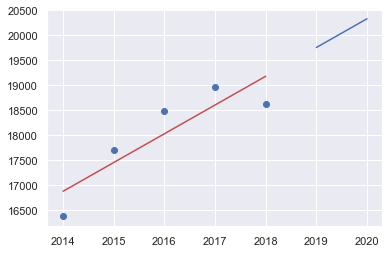

*********************
Auto Theft
*********************
intercept: [-521542.]
slope: [[260.5]]
coefficient of determination: 0.5139331722722488
Prediction of Auto Theft in [[2019]
 [2020]] will be [[4408.]
 [4668.]]


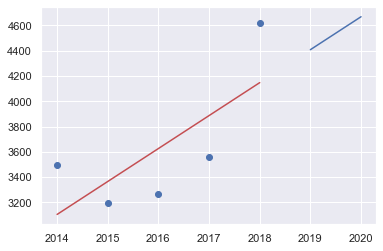

*********************
Break and Enter
*********************
intercept: [-112180.6]
slope: [[59.1]]
coefficient of determination: 0.052751121381001125
Prediction of Break and Enter in [[2019]
 [2020]] will be [[7142.]
 [7201.]]


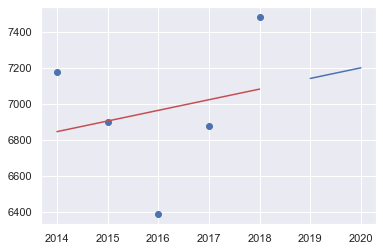

*********************
Other
*********************
intercept: [-4013.]
slope: [[2.]]
coefficient of determination: 0.33333333333333337
Prediction of Other in [[2019]
 [2020]] will be [[25.]
 [27.]]


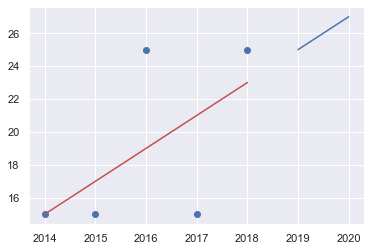

*********************
Robbery
*********************
intercept: [-59080.6]
slope: [[31.1]]
coefficient of determination: 0.08474634189083785
Prediction of Robbery in [[2019]
 [2020]] will be [[3710.]
 [3741.]]


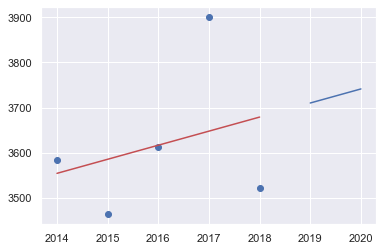

*********************
Shooting
*********************
intercept: [-12260.8]
slope: [[6.1]]
coefficient of determination: 0.8518772893772701
Prediction of Shooting in [[2019]
 [2020]] will be [[55.]
 [61.]]


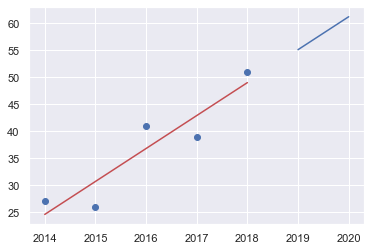

*********************
Stabbing
*********************
intercept: [-186.8]
slope: [[0.1]]
coefficient of determination: 0.0011520737327157526
Prediction of Stabbing in [[2019]
 [2020]] will be [[15.]
 [15.]]


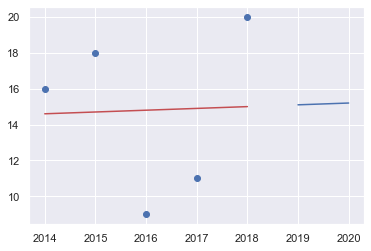

*********************
Theft Over
*********************
intercept: [-84415.4]
slope: [[42.4]]
coefficient of determination: 0.789252787777707
Prediction of Theft Over in [[2019]
 [2020]] will be [[1190.]
 [1233.]]


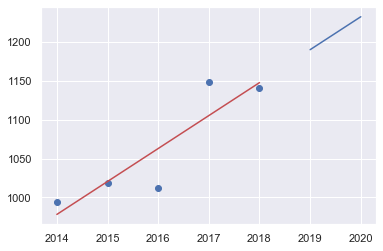

In [211]:
#cycle through each row and make prediction
for i in range(len(mci_ct)):
    name = mci_ct.iloc[i:i+1].index[0]
    y = mci_ct.iloc[i:i+1].values
    x =mci_ct.columns.values
    LinearRegGroup(x,y,name)

## 2nd order polynomial regression

In [212]:
def PolynomialRegressionGroup(x,y,name, d):
    yearsToPredict = np.array([[2019],[2020]])
        
    x=x.reshape((-1,1))
    y=y.reshape((-1,1))
    
    poly_reg = PolynomialFeatures(degree=d)
    x_poly = poly_reg.fit_transform(x)
    pol_reg = LinearRegression()
    pol_reg.fit(x_poly, y)

    pred = pol_reg.predict(poly_reg.fit_transform(yearsToPredict))
        
    print('*********************')
    print(name)
    print('*********************')
        
    # Visualizing the Polymonial Regression results

    plt.scatter(x, y, color='red')
    plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='blue')  
    plt.plot(yearsToPredict,pred,'-r')
    plt.show()

    print('Polynomical Predict for ', yearsToPredict , np.round(pred,0))

*********************
Assault
*********************


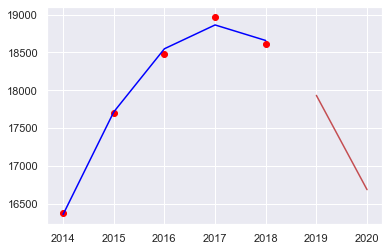

Polynomical Predict for  [[2019]
 [2020]] [[17933.]
 [16686.]]
*********************
Auto Theft
*********************


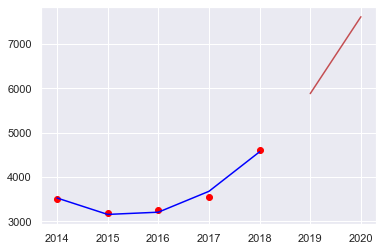

Polynomical Predict for  [[2019]
 [2020]] [[5880.]
 [7613.]]
*********************
Break and Enter
*********************


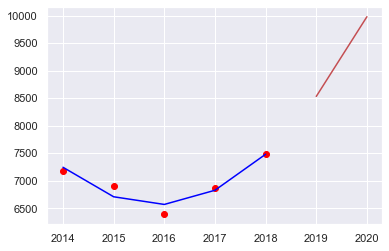

Polynomical Predict for  [[2019]
 [2020]] [[8531.]
 [9978.]]
*********************
Other
*********************


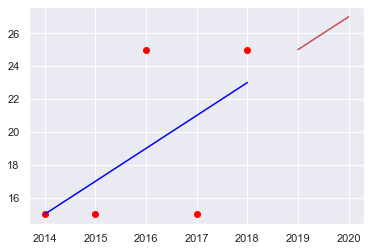

Polynomical Predict for  [[2019]
 [2020]] [[25.]
 [27.]]
*********************
Robbery
*********************


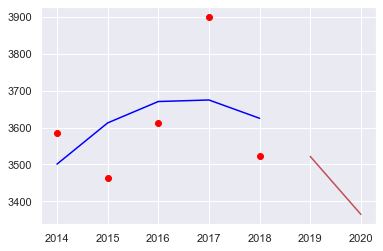

Polynomical Predict for  [[2019]
 [2020]] [[3522.]
 [3364.]]
*********************
Shooting
*********************


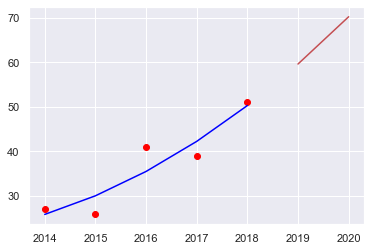

Polynomical Predict for  [[2019]
 [2020]] [[60.]
 [70.]]
*********************
Stabbing
*********************


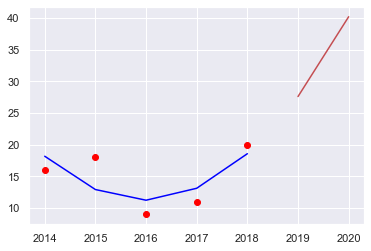

Polynomical Predict for  [[2019]
 [2020]] [[28.]
 [40.]]
*********************
Theft Over
*********************


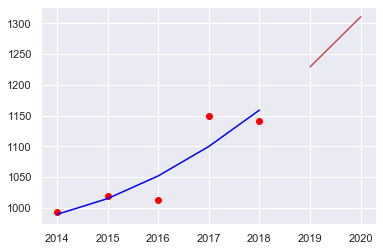

Polynomical Predict for  [[2019]
 [2020]] [[1229.]
 [1311.]]


In [213]:
for i in range(len(mci_ct)):
    name = mci_ct.iloc[i:i+1].index[0]
    y = mci_ct.iloc[i:i+1].values
    x =mci_ct.columns.values
    PolynomialRegressionGroup(x,y,name,2)

## 3rd order polynomial regression

*********************
Assault
*********************


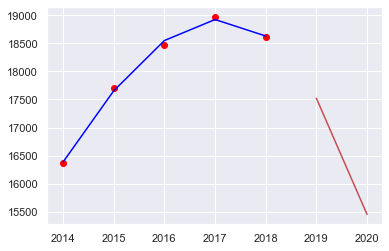

Polynomical Predict for  [[2019]
 [2020]] [[17522.]
 [15453.]]
*********************
Auto Theft
*********************


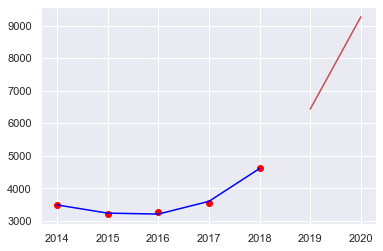

Polynomical Predict for  [[2019]
 [2020]] [[6431.]
 [9270.]]
*********************
Break and Enter
*********************


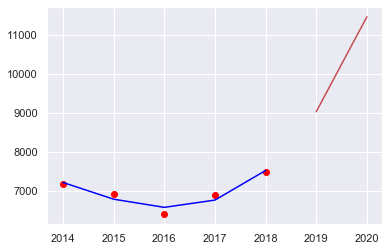

Polynomical Predict for  [[2019]
 [2020]] [[ 9027.]
 [11466.]]
*********************
Other
*********************


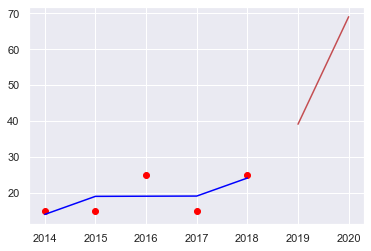

Polynomical Predict for  [[2019]
 [2020]] [[39.]
 [69.]]
*********************
Robbery
*********************


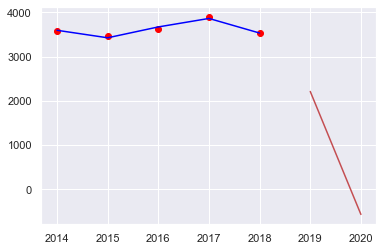

Polynomical Predict for  [[2019]
 [2020]] [[2211.]
 [-571.]]
*********************
Shooting
*********************


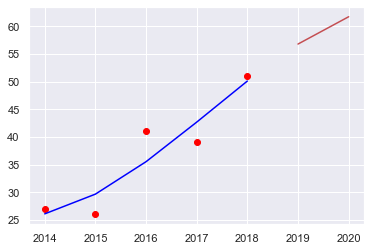

Polynomical Predict for  [[2019]
 [2020]] [[57.]
 [62.]]
*********************
Stabbing
*********************


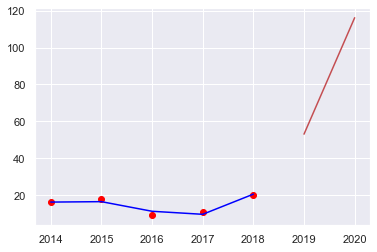

Polynomical Predict for  [[2019]
 [2020]] [[ 53.]
 [116.]]
*********************
Theft Over
*********************


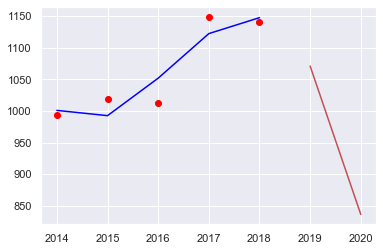

Polynomical Predict for  [[2019]
 [2020]] [[1071.]
 [ 836.]]


In [214]:
for i in range(len(mci_ct)):
    name = mci_ct.iloc[i:i+1].index[0]
    y = mci_ct.iloc[i:i+1].values
    x =mci_ct.columns.values
    PolynomialRegressionGroup(x,y,name,3)

Looking at regression models it seems to me that the best model to choose is linear regression. The reason for the chose is that it seems to me that 2nd and 3rd order regressions are overfitting and overly optimistic or pessimistic. 

# Seasonality Analysis

In [216]:
#Set Occurance date as index
mci_ts = mci_df.set_index('occurrencedate')
mci_ts

,index,occurrenceyear,occurrencemonth,division,Hood_ID,type,neighbourhood,Lat,Long,merged1,occurrenceday,occurrencedayofweek
occurrencedate,,,,,,,,,,,,
2014-01-14 05:00:00,827,2014,Jan,D41,126,Other,Dorset Park (126),43.759132,-79.289589,Homicide,14,1
2014-01-29 05:00:00,829,2014,Jan,D23,8,Shooting,Humber Heights-Westmount (8),43.694614,-79.517342,Homicide,29,2
2014-01-29 05:00:00,830,2014,Jan,D43,137,Other,Woburn (137),43.770390,-79.220123,Homicide,29,2
2014-02-02 05:00:00,831,2014,Jan,D54,54,Stabbing,O'Connor-Parkview (54),43.702221,-79.297287,Homicide,2,6
2014-02-03 05:00:00,832,2014,Jan,D41,119,Other,Wexford/Maryvale (119),43.769482,-79.302269,Homicide,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-16 20:30:00,179392,2018,Jan,D54,43,Auto Theft,Victoria Village (43),43.718910,-79.304466,Auto Theft,16,2
2018-05-24 18:00:00,179393,2018,Jan,D55,62,Auto Theft,East End-Danforth (62),43.684856,-79.297562,Auto Theft,24,3
2018-05-24 19:00:00,179394,2018,Jan,D41,122,Auto Theft,Birchcliffe-Cliffside (122),43.685402,-79.274391,Auto Theft,24,3


In [217]:
mci_ts['occurrenceyear']
mci_ts[['occurrenceyear']]


,occurrenceyear
occurrencedate,
2014-01-14 05:00:00,2014
2014-01-29 05:00:00,2014
2014-01-29 05:00:00,2014
2014-02-02 05:00:00,2014
2014-02-03 05:00:00,2014
...,...
2018-05-16 20:30:00,2018
2018-05-24 18:00:00,2018
2018-05-24 19:00:00,2018


## Autocorrelation

In [218]:
#Resample monthly and weekly
#We need to drop NA because during resampling N/A might be added 
mci_ts_monthly = mci_ts.occurrenceyear.resample('M').count()
mci__ts_monthly = mci_ts_monthly.dropna()
mci_ts_weekly = mci_ts.occurrenceyear.resample('W').count()
mci_ts_weekly = mci_ts_weekly.dropna()

In [219]:
#Autocorrelation formatted plot
def AutocorrelationFormatedPlot(stock, symbol):
    TimePlot = pd.plotting.autocorrelation_plot(stock, color='r')
    title = symbol + " Autocorrelation Graph"
    TimePlot.set_title(title)
    TimePlot.set_ylabel("Correlation")
    TimePlot.set_xlabel("Lag Month")
    None

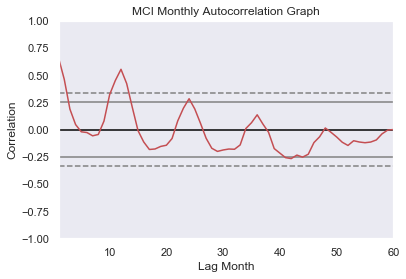

In [220]:
AutocorrelationFormatedPlot(mci_ts_monthly,"MCI Monthly")

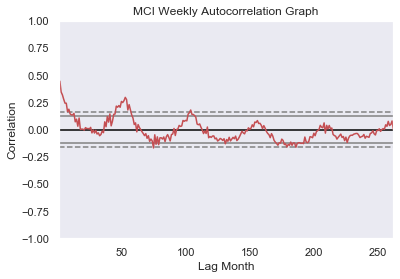

In [221]:
AutocorrelationFormatedPlot(mci_ts_weekly,"MCI Weekly")

Monthly autocorrelation shows that there is correlation in the first 5 months , and 12 months


Weekly trend has correlation in first 15 weeks and follows by correlation at 50 weeks.

## Montly and weekly plots

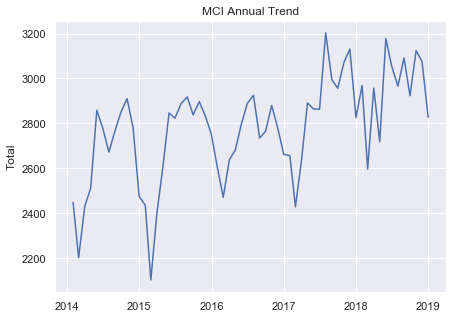

In [222]:
plt.figure(figsize=(7,5))
plt.ylabel('Total')
plt.title('MCI Annual Trend')
plt.plot(mci_ts_monthly)

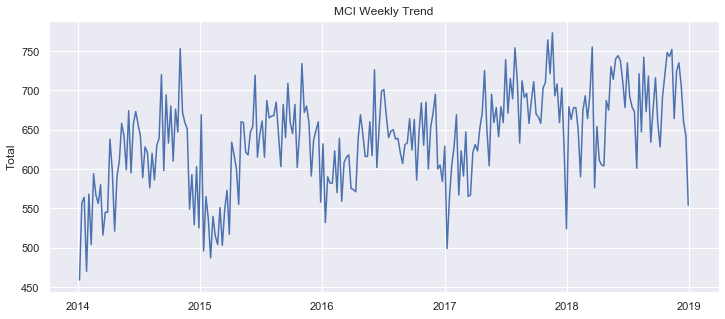

In [223]:
#during re-sampling last few days are shifted to 2019, therefore, we remove last point from the plot [:-1]
plt.figure(figsize=(12,5))
plt.ylabel('Total')
plt.title('MCI Weekly Trend')
#plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=20)
plt.plot(mci_ts_weekly[:-1])

The number of crimes increases in the middle of the year and goes down in January. 

To get a different perspective, I will calculated total of crime in each month.

In [224]:
monthlyTotal = mci_ts_monthly.loc['2014'].values
for val in range (2015,2019):
    monthlyTotal = monthlyTotal + mci_ts_monthly.loc[str(val)].values

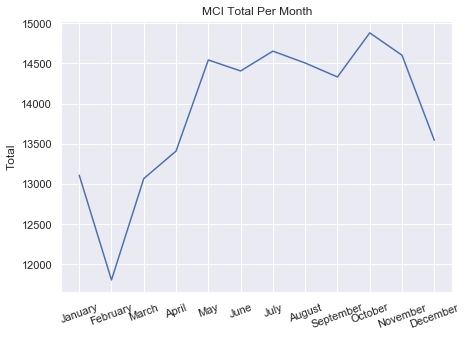

In [225]:
plt.figure(figsize=(7,5))
plt.ylabel('Total')
plt.title('MCI Total Per Month')
plt.xticks(np.arange(12), calendar.month_name[1:13], rotation=20)
plt.plot(monthlyTotal)

In [226]:
print('Monthly Median')
mci_ts_monthly.median()

Monthly Median


2827.0

It is not possible to determine the reason for seasonality from the data itself. Maybe Christmas spirit has something do to with it :)  

### Median of each month 

In [228]:
mci_ts_monthly_ct = pd.crosstab(mci_ts.occurrencemonth, mci_ts.occurrenceyear)
mci_ts_monthly_ct['Median'] = mci_ts_monthly_ct.median(axis=1)
mci_ts_monthly_ct.sort_values('Median',axis = 0, ascending = False,
                 inplace = True)
mci_ts_monthly_ct

occurrenceyear,2014,2015,2016,2017,2018,Median
occurrencemonth,,,,,,
Jan,31686,32341,32826,34522,35478,32826.0


In [ ]:
mci_ts_monthly_ct['Median'].plot(kind='bar', stacked=False, rot = 0, figsize=(10, 7));

In [ ]:
mci_ts_monthly_ct['Median'].plot(stacked=False, rot = 0, figsize=(10, 7));

Taking a closer look at crimes per month we find that: 
- July, August, October have highest median number of crimes
- March, January, February have lowest median number of crimes


## MCI Prediction model

I will build a model that will predict type of MCI based on location of crime. 

The following alogrithms will be tested
- KNeighborsClassifier
- DecisionTreeClassifier

In [230]:
x = mci_df[['Lat', 'Long']].values
print(type(x))
x

<class 'numpy.ndarray'>


array([[ 43.7591324, -79.2895889],
       [ 43.6946144, -79.5173416],
       [ 43.7703896, -79.2201233],
       ...,
       [ 43.6854019, -79.2743912],
       [ 43.6867599, -79.5955658],
       [ 43.7753639, -79.4811783]])

In [231]:
y = mci_df[['type']].values.flatten()
print(type(y))
y

<class 'numpy.ndarray'>


array(['Other', 'Shooting', 'Other', ..., 'Auto Theft', 'Auto Theft',
       'Auto Theft'], dtype=object)

In [232]:
#Split data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [233]:
#Evaluation function
def Evaluate(predicted, y_test):
    true_pred = np.sum(predicted == y_test)
    total_pred = predicted.shape[0]
    print('True predictions', true_pred, 'out of', total_pred)
    print('Percent of correct predictions', round(100*true_pred/total_pred,2), '%')
    

# KNeighborsClassifier

In [234]:
from sklearn.neighbors import KNeighborsClassifier

In [235]:
#Define Model
knc = KNeighborsClassifier(n_neighbors =15) # 	n_neighbors : int, optional (default = 5)
#Train
knc = knc.fit(x_train, y_train)
#Predict
resKN = knc.predict(x_test)
#Evaluate
Evaluate(resKN,y_test)
#convert resKN to dataframe 
resKN_df =pd.DataFrame({'knc': resKN[:]})

resKN_df.head(10)

True predictions 18955 out of 33371
Percent of correct predictions 56.8 %


,knc
0,Auto Theft
1,Assault
2,Assault
3,Assault
4,Assault
5,Assault
6,Assault
7,Auto Theft
8,Assault
9,Auto Theft


I have tested different values for n_neighbors, if n_neighbors =5 the error is higher than when n_neighbors =15. Further increase of n_neighbors does not produce better results.

## Decision Tree Classifier

In [236]:
from sklearn.tree import DecisionTreeClassifier

In [237]:
dtc = DecisionTreeClassifier(max_depth=20)
dtc = dtc.fit(x_train,y_train)
resDtc = dtc.predict(x_test)
Evaluate(resDtc,y_test)
dtc_df =pd.DataFrame({'dtc': resDtc[:]})
dtc_df.head()

True predictions 19064 out of 33371
Percent of correct predictions 57.13 %


,dtc
0,Auto Theft
1,Assault
2,Assault
3,Assault
4,Assault


I have tested different max_depth, found that increasing max_depth pass 20 does not produce better results. 

# LogisticRegression

In [238]:
from sklearn.linear_model import LogisticRegression

In [239]:
lr = LogisticRegression(random_state=0)
lr = lr.fit(x_train, y_train)
resLr = lr.predict(x_test)
Evaluate(resLr,y_test)

lr_df =pd.DataFrame({'lr': resLr[:]})
lr_df.head()

C:\Users\mgishu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mgishu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


True predictions 18069 out of 33371
Percent of correct predictions 54.15 %


,lr
0,Assault
1,Assault
2,Assault
3,Assault
4,Assault


# Voting for most frequent prediction

I have 3 predictions. To improve prediction results I will create voting algorithm.

If 2 out of 3 predictions are the same, I will choose that prediction, otherwise I will select 1st column by default
The logic is this 

If (a==b) or (a==c) then select a

Ifelse (b==c) then select b

Else select a by default

Above can be transformed to the following statement 

If (b==c) then select b

Else select a by default




In [240]:
df_predict = resKN_df.join(dtc_df)
df_predict = df_predict.join(lr_df)
#df_predict.head()

In [241]:
df_predict_votes = df_predict.copy()

In [242]:
df_predict_votes.head()

,knc,dtc,lr
0,Auto Theft,Auto Theft,Assault
1,Assault,Assault,Assault
2,Assault,Assault,Assault
3,Assault,Assault,Assault
4,Assault,Assault,Assault


In [243]:
df_predict_votes['vote'] = 'none'
df_predict_votes.head()

,knc,dtc,lr,vote
0,Auto Theft,Auto Theft,Assault,none
1,Assault,Assault,Assault,none
2,Assault,Assault,Assault,none
3,Assault,Assault,Assault,none
4,Assault,Assault,Assault,none


In [245]:
for items, vals in df_predict_votes.iterrows():    
    if(vals['dtc'] == vals['lr']):
        vals['vote'] = vals['dtc']
    else:
        vals['vote'] = vals['knc']
    
    #print(items, vals['knc'],vals['dtc'],vals['lr'], vals['vote'])

In [246]:
y_voted =df_predict_votes[['vote']].values.flatten()
print(type(y_voted))
y_voted

<class 'numpy.ndarray'>


array(['Auto Theft', 'Assault', 'Assault', ..., 'Assault', 'Assault',
       'Assault'], dtype=object)

In [247]:
Evaluate(y_voted,y_test)

True predictions 19135 out of 33371
Percent of correct predictions 57.34 %


It looks like voting did not add much to the model. Personally I am not surprised to see low rate of prediction. The type of crime does not depend on location, and it is distributed by chance. 

<b>
The data were taken from various sources and may not be accurate. Also, I am sure of it , I made a few mistakes in my calculations. 

Please take a good look at the quality of data, and errors, before using this notebook. 
</b>